## POS tagging using modified Viterbi

### Data Preparation

In [165]:
# importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [166]:
# downloading universal tagset
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\prash\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [167]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [168]:
# reading first three tagged sentences
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [169]:
# Splitting into train and validation set - 95% train and 5% validation
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(validation_set))
print(train_set[:2])

3718
196
[[('The', 'DET'), ('Treasury', 'NOUN'), ('plans', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('sell', 'VERB'), ('$', '.'), ('30', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('notes', 'NOUN'), ('and', 'CONJ'), ('bonds', 'NOUN'), ('next', 'ADP'), ('week', 'NOUN'), ('but', 'CONJ'), ('will', 'VERB'), ('delay', 'VERB'), ('the', 'DET'), ('auction', 'NOUN'), ('unless', 'ADP'), ('Congress', 'NOUN'), ('quickly', 'ADV'), ('raises', 'VERB'), ('the', 'DET'), ('debt', 'NOUN'), ('ceiling', 'NOUN'), ('.', '.')], [('Dan', 'NOUN'), ('E.', 'NOUN'), ('Nelms', 'NOUN'), (',', '.'), ('Valley', 'NOUN'), ('Federal', 'NOUN'), ("'s", 'PRT'), ('president', 'NOUN'), ('and', 'CONJ'), ('chief', 'ADJ'), ('executive', 'NOUN'), ('officer', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('one-time', 'ADJ'), ('charge', 'NOUN'), ('substantially', 'ADV'), ('eliminates', 'VERB'), ('future', 'ADJ'), ('losses', 'NOUN'), ('associated', 'VERB'), ('*', 'X'), ('with', 'ADP'), ('the', 'DET'),

In [170]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
train_tagged_words[:10]

[('The', 'DET'),
 ('Treasury', 'NOUN'),
 ('plans', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('sell', 'VERB'),
 ('$', '.'),
 ('30', 'NUM'),
 ('billion', 'NUM'),
 ('*U*', 'X')]

In [171]:
# identify tokens in the train list 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The', 'Treasury', 'plans', '*-1', 'to', 'sell', '$', '30', 'billion', '*U*']

In [172]:
# vocabulary in the train list
V = set(tokens)
print(len(V))

12052


In [173]:
# number of tags in the train list
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [174]:
# Printing tags
print(T)

{'ADV', 'ADP', 'NUM', 'DET', 'X', '.', 'CONJ', 'NOUN', 'ADJ', 'PRON', 'PRT', 'VERB'}


##### NLTK universal tagset from NLTK website

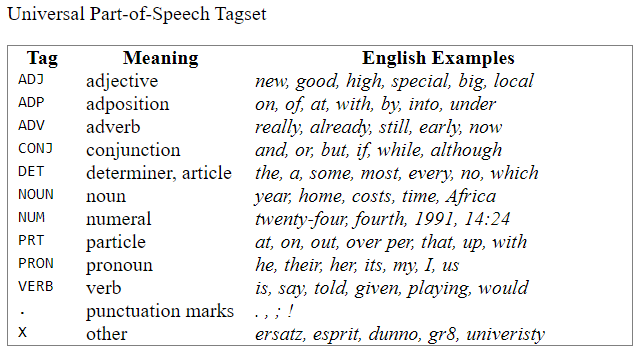

### Build the vanilla Viterbi based POS tagger

In [175]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [176]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [177]:
tags_matrix

array([[8.06559548e-02, 1.18139222e-01, 3.11244987e-02, 6.79384172e-02,
        2.37617139e-02, 1.35207504e-01, 7.02811265e-03, 3.14591713e-02,
        1.29852742e-01, 1.50602413e-02, 1.47255687e-02, 3.45046848e-01],
       [1.33304661e-02, 1.67705864e-02, 6.27821982e-02, 3.25198889e-01,
        3.42937000e-02, 3.98838967e-02, 9.67533852e-04, 3.21866274e-01,
        1.05998710e-01, 6.92324266e-02, 1.39754894e-03, 8.27778969e-03],
       [2.97796307e-03, 3.48421670e-02, 1.85229301e-01, 3.27575929e-03,
        2.09053010e-01, 1.20011911e-01, 1.39964260e-02, 3.50804061e-01,
        3.27575952e-02, 1.19118521e-03, 2.79928520e-02, 1.78677794e-02],
       [1.23411976e-02, 9.31639411e-03, 2.23835446e-02, 5.44464588e-03,
        4.53720503e-02, 1.76648516e-02, 4.83968528e-04, 6.36539638e-01,
        2.06170604e-01, 3.75075615e-03, 2.41984264e-04, 4.02903818e-02],
       [2.59282961e-02, 1.43565938e-01, 2.72087078e-03, 5.58578745e-02,
        7.60243312e-02, 1.64532647e-01, 1.02432780e-02, 6.12

In [178]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [179]:
tags_df

,ADV,ADP,NUM,DET,X,.,CONJ,NOUN,ADJ,PRON,PRT,VERB
ADV,0.080656,0.118139,0.031124,0.067938,0.023762,0.135208,0.007028,0.031459,0.129853,0.015060,0.014726,0.345047
ADP,0.013330,0.016771,0.062782,0.325199,0.034294,0.039884,0.000968,0.321866,0.105999,0.069232,0.001398,0.008278
NUM,0.002978,0.034842,0.185229,0.003276,0.209053,0.120012,0.013996,0.350804,0.032758,0.001191,0.027993,0.017868
DET,0.012341,0.009316,0.022384,0.005445,0.045372,0.017665,0.000484,0.636540,0.206171,0.003751,0.000242,0.040290
X,0.025928,0.143566,0.002721,0.055858,0.076024,0.164533,0.010243,0.061300,0.017125,0.055858,0.184699,0.202145
.,0.051971,0.092123,0.080123,0.174321,0.027068,0.093928,0.058197,0.221420,0.043670,0.065686,0.002436,0.088965
CONJ,0.053147,0.053613,0.041026,0.120280,0.008392,0.036364,0.000466,0.349650,0.116084,0.057809,0.005128,0.158042
NOUN,0.016817,0.176684,0.009547,0.013035,0.028933,0.240095,0.042666,0.263264,0.012117,0.004700,0.044061,0.148082
ADJ,0.004303,0.077789,0.021020,0.004634,0.020357,0.064548,0.016551,0.701258,0.066700,0.000662,0.011255,0.010924
PRON,0.034403,0.023579,0.007344,0.009664,0.089293,0.040588,0.005412,0.207576,0.074990,0.008118,0.011210,0.487824


In [180]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [181]:
# plain vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [182]:
# Running on entire test dataset would take lots of time. 
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

random.seed(1234)

# choose random 10 sents
rndom = [random.randint(1,len(validation_set)) for x in range(10)]

# list of sents
test_run = [validation_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run


[[('Virginia', 'NOUN'), (':', '.')],
 [('He', 'PRON'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('authors', 'NOUN'),
  ('of', 'ADP'),
  ('Scoring', 'NOUN'),
  ('High', 'NOUN'),
  ('``', '.'),
  ('scrupulously', 'ADV'),
  ('avoid', 'VERB'),
  ("''", '.'),
  ('*-1', 'X'),
  ('replicating', 'VERB'),
  ('exact', 'ADJ'),
  ('questions', 'NOUN'),
  (',', '.'),
  ('but', 'CONJ'),
  ('he', 'PRON'),
  ('does', 'VERB'),
  ("n't", 'ADV'),
  ('deny', 'VERB'),
  ('that', 'ADP'),
  ('some', 'DET'),
  ('items', 'NOUN'),
  ('are', 'VERB'),
  ('similar', 'ADJ'),
  ('.', '.')],
 [('Komatsu', 'NOUN'),
  ('Ltd.', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('large', 'ADJ'),
  ('integrated', 'VERB'),
  ('maker', 'NOUN'),
  ('of', 'ADP'),
  ('construction', 'NOUN'),
  ('machinery', 'NOUN'),
  (',', '.'),
  ('posted', 'VERB'),
  ('a', 'DET'),
  ('32', 'NUM'),
  ('%', 'NOUN'),
  ('unconsolidated', 'ADJ'),
  ('gain', 'NOUN'),
  ('in', 'ADP'),
  ('first-half', 'ADJ'),
  ('pretax', 'NOUN'),
  ('profit', 'NOUN'),
  ('.',

In [183]:
# tagging the validation sentences
tagged_seq = Viterbi(test_tagged_words)

In [184]:
print(tagged_seq)

[('Virginia', 'NOUN'), (':', '.'), ('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('authors', 'NOUN'), ('of', 'ADP'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('``', '.'), ('scrupulously', 'ADV'), ('avoid', 'VERB'), ("''", '.'), ('*-1', 'X'), ('replicating', 'ADV'), ('exact', 'ADJ'), ('questions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('he', 'PRON'), ('does', 'VERB'), ("n't", 'ADV'), ('deny', 'VERB'), ('that', 'ADP'), ('some', 'DET'), ('items', 'NOUN'), ('are', 'VERB'), ('similar', 'ADJ'), ('.', '.'), ('Komatsu', 'NOUN'), ('Ltd.', 'NOUN'), (',', '.'), ('a', 'DET'), ('large', 'ADJ'), ('integrated', 'ADJ'), ('maker', 'NOUN'), ('of', 'ADP'), ('construction', 'NOUN'), ('machinery', 'NOUN'), (',', '.'), ('posted', 'VERB'), ('a', 'DET'), ('32', 'NUM'), ('%', 'NOUN'), ('unconsolidated', 'ADV'), ('gain', 'VERB'), ('in', 'ADP'), ('first-half', 'ADJ'), ('pretax', 'NOUN'), ('profit', 'NOUN'), ('.', '.'), ('Cathryn', 'NOUN'), ('Rice', 'NOUN'), ('could', 'VERB'), ('hardly', 'ADV'), ('believe', 'VERB')

In [185]:
# accuracy with vanilla Viterbi
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [186]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9193548387096774

### Solve the problem of unknown words

In [187]:
# Modified the Viterbi algorithm to handle the issues related to tagging unknown word

In [188]:
# Viterbi Heuristic (modified 1)
def Viterbi_mod1(words, train_bag = train_tagged_words):
    state = [] # initialized tag states
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] #this list is leveraged for storing the state probabilities where emission probability is non zero
        pmodified = [] #this list is leveraged for storing the state probabilities for items having zero emission probability
        emission_probab = [] # stores the emission probability for a given word
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            emission_probab.append(emission_p) # stores emission probability
            state_probability = emission_p * transition_p # derives vanilla state probability
            state_probability_modified = 0.01 * transition_p # derives modified state probability where emission probability = 0
            p.append(state_probability) # stores vanilla state probability
            pmodified.append(state_probability_modified) # stores modified state probability
            
        emission_probab_max = max(emission_probab) # calculates the maximum of the emission probabilities stored
        if emission_probab_max == 0:# if emission probability is zero the word is a unknown word
            pmax = max(pmodified) # for unknown words consider maximum of modified probability
            state_max = T[pmodified.index(pmax)] 
        else: # for non zero emission probability
            pmax = max(p) # for known words consider max of vanilla state probability
            state_max = T[p.index(pmax)]
        
        # getting state for which probability is maximum
        #state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [189]:
# tagging the validation sentences with modified Viterbi

tagged_seq1 = Viterbi_mod1(test_tagged_words)

In [190]:
print(tagged_seq1)

[('Virginia', 'NOUN'), (':', '.'), ('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('authors', 'NOUN'), ('of', 'ADP'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('``', '.'), ('scrupulously', 'NOUN'), ('avoid', 'VERB'), ("''", '.'), ('*-1', 'X'), ('replicating', 'VERB'), ('exact', 'ADJ'), ('questions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('he', 'PRON'), ('does', 'VERB'), ("n't", 'ADV'), ('deny', 'VERB'), ('that', 'ADP'), ('some', 'DET'), ('items', 'NOUN'), ('are', 'VERB'), ('similar', 'ADJ'), ('.', '.'), ('Komatsu', 'NOUN'), ('Ltd.', 'NOUN'), (',', '.'), ('a', 'DET'), ('large', 'ADJ'), ('integrated', 'ADJ'), ('maker', 'NOUN'), ('of', 'ADP'), ('construction', 'NOUN'), ('machinery', 'NOUN'), (',', '.'), ('posted', 'VERB'), ('a', 'DET'), ('32', 'NUM'), ('%', 'NOUN'), ('unconsolidated', 'NOUN'), ('gain', 'NOUN'), ('in', 'ADP'), ('first-half', 'ADJ'), ('pretax', 'NOUN'), ('profit', 'NOUN'), ('.', '.'), ('Cathryn', 'NOUN'), ('Rice', 'NOUN'), ('could', 'VERB'), ('hardly', 'ADV'), ('believe', 'VER

In [191]:
# accuracy
check1 = [i for i, j in zip(tagged_seq1, test_run_base) if i == j] 

In [192]:
accuracy1 = len(check1)/len(tagged_seq1)
accuracy1

0.9408602150537635

In [193]:
# modification -2: rule based modification

In [194]:
# define patterns for tagging 
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),             # modals
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

In [195]:
# Rule based tagger
regexp_tagger = nltk.RegexpTagger(patterns)

In [196]:
# Viterbi Heuristic (modified 2)
def Viterbi_mod2(words, train_bag = train_tagged_words):
    state = [] # initialized tag states
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] #this list is leveraged for storing the state probabilities where emission probability is non zero
        pmodified = [] #this list is leveraged for storing the state probabilities where emission probability is zero
        emission_probab = [] # stores the emission probability for a given word
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            emission_probab.append(emission_p) # stores emission probability
            state_probability = emission_p * transition_p # derives vanilla state probability
            state_probability_modified = 0.02 * transition_p # derives modified state probability where emission probability = 0
            p.append(state_probability) # stores vanilla state probability
            pmodified.append(state_probability_modified) # stores modified state probability
            
        emission_probab_max = max(emission_probab)
        if emission_probab_max == 0:
            state_max = regexp_tagger.tag([word])[0][1]  # rule base tagger called
        else:
            pmax = max(p)
            state_max = T[p.index(pmax)]
        
        # getting state for which probability is maximum
        #state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [197]:
# tagging the validation sentences with modified Viterbi

tagged_seq2 = Viterbi_mod2(test_tagged_words)

In [198]:
print(tagged_seq2)

[('Virginia', 'NOUN'), (':', '.'), ('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('authors', 'NOUN'), ('of', 'ADP'), ('Scoring', 'NOUN'), ('High', 'NOUN'), ('``', '.'), ('scrupulously', 'NOUN'), ('avoid', 'VERB'), ("''", '.'), ('*-1', 'X'), ('replicating', 'VERB'), ('exact', 'ADJ'), ('questions', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('he', 'PRON'), ('does', 'VERB'), ("n't", 'ADV'), ('deny', 'VERB'), ('that', 'ADP'), ('some', 'DET'), ('items', 'NOUN'), ('are', 'VERB'), ('similar', 'ADJ'), ('.', '.'), ('Komatsu', 'NOUN'), ('Ltd.', 'NOUN'), (',', '.'), ('a', 'DET'), ('large', 'ADJ'), ('integrated', 'ADJ'), ('maker', 'NOUN'), ('of', 'ADP'), ('construction', 'NOUN'), ('machinery', 'NOUN'), (',', '.'), ('posted', 'VERB'), ('a', 'DET'), ('32', 'NUM'), ('%', 'NOUN'), ('unconsolidated', 'VERB'), ('gain', 'NOUN'), ('in', 'ADP'), ('first-half', 'ADJ'), ('pretax', 'NOUN'), ('profit', 'NOUN'), ('.', '.'), ('Cathryn', 'NOUN'), ('Rice', 'NOUN'), ('could', 'VERB'), ('hardly', 'ADV'), ('believe', 'VER

In [199]:
# accuracy
check2 = [i for i, j in zip(tagged_seq2, test_run_base) if i == j] 

In [200]:
accuracy2 = len(check2)/len(tagged_seq2)
accuracy2

0.9408602150537635

#### Evaluating tagging accuracy

##### Tagging accuracies on validation set is evaluated in the above section alongwith the vanilla Viterbi and modification. These accuracies are printed here for comparison

In [201]:
# tagging accuracy of vanilla viterbi algorithm
accuracy

0.9193548387096774

In [202]:
# tagging accuracy of modified viterbi algorithm - 1st modification as defined by Viterbi_mod1
accuracy1

0.9408602150537635

In [203]:
# tagging accuracy of modified viterbi algorithm - 2nd modification as defined by Viterbi_mod2
accuracy2

0.9408602150537635

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [204]:
# On validation set 
# tagging accuracies

print("Vanilla Viterbi algorithm =", accuracy) 
print("Modified Viterbi algorithm (laplacian smoothing) =", accuracy1)
print("Modified Viterbi (rule based) =", accuracy2)

Vanilla Viterbi algorithm = 0.9193548387096774
Modified Viterbi algorithm (laplacian smoothing) = 0.9408602150537635
Modified Viterbi (rule based) = 0.9408602150537635


In [205]:
# on Test data
#Reading the test file
fo = open("Test_sentences.txt", "r+")

text = fo.readlines()
print (text)

# Close opened file
fo.close()

['Android is a mobile operating system developed by Google.\n', 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n', "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n", 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n', 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n', 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n', 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n', 'Show me the cheapest round trips from Dallas to Atlanta\n', 'I would like to see flights from Denver to Philadelphia.\n', 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n', 'NASA invited social media users to

In [206]:
# stripping the blankspaces from the text 

line_revised =[sentence.strip() for sentence in text if sentence.strip()!='']
line_revised

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [207]:
words_tokenized = [word_tokenize(sen) for sen in line_revised]

In [208]:
# making predictions on the test sentences by leveraging plain viterbi algorithm
list_ts =[]
for temp in line_revised:
    list_ts.append(Viterbi(word_tokenize(temp)))
print(list_ts)

[[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.')], [('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.')], [('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.')], [('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users

In [209]:
# making predictions on the test sentences by leveraging modified viterbi algorithm (Viterbi_mod1)
list_ts =[]
for temp in line_revised:
    list_ts.append(Viterbi_mod1(word_tokenize(temp)))
print(list_ts)

[[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')], [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')], [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')], [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'),

In [210]:
# making predictions on the test sentences by leveraging modified viterbi algorithm (Viterbi_mod2)
list_ts =[]
for temp in line_revised:
    list_ts.append(Viterbi_mod2(word_tokenize(temp)))
print(list_ts)

[[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')], [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')], [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')], [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'D

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [211]:
# lets identify the words in the test file that we have tagged

test_words = [tup for sent in list_ts for tup in sent]
tokens_test = [pair[0] for pair in test_words]
tokens_test

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [212]:
# words in the test file that are not there in the train data

words_notintrain = list(set(tokens_test) - set(tokens))
words_notintrain

['arriving',
 '2013',
 'interact',
 'contested',
 '2015',
 'invited',
 'Twitter',
 'Google',
 'ICESAT-2',
 'OS',
 '2018',
 'personality',
 'messages',
 'smartphones',
 'trips',
 'FIFA',
 'Android',
 'online',
 'Satellite',
 '2011',
 'Cup',
 'tweets',
 'tournament',
 'NASA',
 'domineering',
 'firehose',
 '21st',
 'worldwide']

In [213]:
viterbi_test = Viterbi(words_notintrain)
viterbi_test

[('arriving', 'ADV'),
 ('2013', 'ADV'),
 ('interact', 'ADV'),
 ('contested', 'ADV'),
 ('2015', 'ADV'),
 ('invited', 'ADV'),
 ('Twitter', 'ADV'),
 ('Google', 'ADV'),
 ('ICESAT-2', 'ADV'),
 ('OS', 'ADV'),
 ('2018', 'ADV'),
 ('personality', 'ADV'),
 ('messages', 'ADV'),
 ('smartphones', 'ADV'),
 ('trips', 'ADV'),
 ('FIFA', 'ADV'),
 ('Android', 'ADV'),
 ('online', 'ADV'),
 ('Satellite', 'ADV'),
 ('2011', 'ADV'),
 ('Cup', 'ADV'),
 ('tweets', 'ADV'),
 ('tournament', 'ADV'),
 ('NASA', 'ADV'),
 ('domineering', 'ADV'),
 ('firehose', 'ADV'),
 ('21st', 'ADV'),
 ('worldwide', 'ADV')]

##### As we can see, Viterbi has classified all the words in test set that are not in train incorrectly

In [214]:
viterbi_mod1_test = Viterbi_mod1(words_notintrain)
viterbi_mod1_test

[('arriving', 'NOUN'),
 ('2013', 'NOUN'),
 ('interact', 'NOUN'),
 ('contested', 'NOUN'),
 ('2015', 'NOUN'),
 ('invited', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('Google', 'NOUN'),
 ('ICESAT-2', 'NOUN'),
 ('OS', 'NOUN'),
 ('2018', 'NOUN'),
 ('personality', 'NOUN'),
 ('messages', 'NOUN'),
 ('smartphones', 'NOUN'),
 ('trips', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Android', 'NOUN'),
 ('online', 'NOUN'),
 ('Satellite', 'NOUN'),
 ('2011', 'NOUN'),
 ('Cup', 'NOUN'),
 ('tweets', 'NOUN'),
 ('tournament', 'NOUN'),
 ('NASA', 'NOUN'),
 ('domineering', 'NOUN'),
 ('firehose', 'NOUN'),
 ('21st', 'NOUN'),
 ('worldwide', 'NOUN')]

In [215]:
viterbi_mod2_test = Viterbi_mod2(words_notintrain)
viterbi_mod2_test

[('arriving', 'VERB'),
 ('2013', 'NUM'),
 ('interact', 'NOUN'),
 ('contested', 'VERB'),
 ('2015', 'NUM'),
 ('invited', 'VERB'),
 ('Twitter', 'NOUN'),
 ('Google', 'NOUN'),
 ('ICESAT-2', 'NOUN'),
 ('OS', 'NOUN'),
 ('2018', 'NUM'),
 ('personality', 'NOUN'),
 ('messages', 'VERB'),
 ('smartphones', 'VERB'),
 ('trips', 'NOUN'),
 ('FIFA', 'NOUN'),
 ('Android', 'NOUN'),
 ('online', 'NOUN'),
 ('Satellite', 'NOUN'),
 ('2011', 'NUM'),
 ('Cup', 'NOUN'),
 ('tweets', 'NOUN'),
 ('tournament', 'NOUN'),
 ('NASA', 'NOUN'),
 ('domineering', 'VERB'),
 ('firehose', 'NOUN'),
 ('21st', 'NOUN'),
 ('worldwide', 'NOUN')]

In [216]:
# merging these three lists

from pandas import DataFrame
df_vv = DataFrame (viterbi_test,columns=['unknown_word','vanila_viterbi_tag'])
df_vm1 = DataFrame (viterbi_mod1_test,columns=['unknown_word','mod1_viterbi_tag'])
df_vm2 = DataFrame (viterbi_mod2_test,columns=['unknown_word','mod2_viterbi_tag'])
merged = pd.merge(df_vv, df_vm1, on='unknown_word')
merged_final = pd.merge(merged, df_vm2, on='unknown_word')
merged_final

,unknown_word,vanila_viterbi_tag,mod1_viterbi_tag,mod2_viterbi_tag
0,arriving,ADV,NOUN,VERB
1,2013,ADV,NOUN,NUM
2,interact,ADV,NOUN,NOUN
3,contested,ADV,NOUN,VERB
4,2015,ADV,NOUN,NUM
5,invited,ADV,NOUN,VERB
6,Twitter,ADV,NOUN,NOUN
7,Google,ADV,NOUN,NOUN
8,ICESAT-2,ADV,NOUN,NOUN
9,OS,ADV,NOUN,NOUN


as we can see, words like Twitter, Google, NASA etc are incorrectly tagged by Vanilla Viterbi in table above. Tagging for these words is corrected to Noun by the modified algorithms.